In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

In [11]:
from src.sympy_utilities import *
from src.BinaryEncodings import *
from src.MatrixToPauliString import *
from src.qiskit_utilities import *

from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Estimator

from ipywidgets import IntProgress
from IPython.display import display, clear_output 

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import scipy.sparse.linalg

import os
import json
import math

In [3]:
h_b_HO = 0.5*(p*p + m*m*q*q)
h_f_HO = -0.5*m#[bdag,b]

ham=Hamiltonian(h_b_HO,h_f_HO,{m:1, g:1}, 8, standard_encode)


In [4]:
hamOP = pauli_string_to_op(ham.pauliStrings)
nq=math.floor(math.log2(ham.hamMatrix.shape[0]))
if not math.log2(ham.hamMatrix.shape[0]).is_integer():
    nq+=1

In [5]:
estimator=Estimator()

In [15]:
results = {}

vqeRuns=10

style = {'description_width': 'initial'}
layout = {'width':'600px'}

entanglement = 'linear'
reps = 1

for i,tol in enumerate([10**(-n) for n in range(1,16)]):

    ansatz = RealAmplitudes(nq, entanglement=entanglement, reps=reps)
    vqe = VQE(estimator=estimator, ansatz=ansatz, optimizer=COBYLA(maxiter=10000, tol=tol))

    values=[]
    iters=[]
    progress = IntProgress(min=0, max=vqeRuns, description="Running VQE with {} tol".format(tol), style=style, layout=layout)
    display(progress)

    for run in range(vqeRuns):
        result=vqe.compute_minimum_eigenvalue(hamOP)
        values.append(result.eigenvalue.real)
        iters.append(result.cost_function_evals)
        progress.value += 1

    if str(tol) in results:
        for value in values:
            results[tol]["eigenvalues"].append(value)
        for iter in iters:
            results[tol]["iters"].append(iter)

    else:
        results[tol]={"eigenvalues": values, "iters": iters}

    clear_output()


Min energy = -4.4409e-16


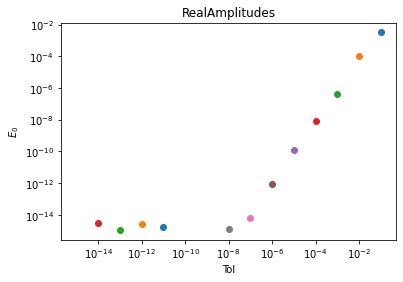

In [17]:
data=results

amp='RealAmplitudes'


markersize=8


#CLASSICAL COMPUTATION OF GROUND STATE ENERGY
ens=scipy.sparse.linalg.eigs(getMatrix(ham.pauliStrings),k=7,sigma=0.0)[0]
#print("Lowest 7 energies = {}".format(ens))
minE=np.array([x.real for x in ens]).min()
print("Min energy = {:.4e}".format(minE))


entanglement = 'linear'
eMin = []
iters = []

rep=1

for i,tol in enumerate([10**(-n) for n in range(1,16)]):
    res=data[tol]
    minIdx = np.argmin(np.array(res['eigenvalues']))
    eval=res['eigenvalues'][minIdx]
    iter=res['iters'][minIdx]

    if iter==10000:
        plt.plot(tol, eval, marker='o', markerfacecolor='none')
    else:
        plt.plot(tol, eval, marker='o')

plt.axhline(minE)

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Tol')
plt.ylabel(r'$E_0$')

plt.title(amp)
plt.show()




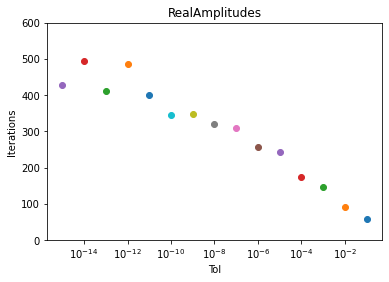

In [21]:
for i,tol in enumerate([10**(-n) for n in range(1,16)]):
    res=data[tol]
    minIdx = np.argmin(np.array(res['eigenvalues']))
    eval=res['eigenvalues'][minIdx]
    iter=res['iters'][minIdx]

    plt.plot(tol, iter, marker='o')


plt.axhline(10000)

plt.xscale('log')
plt.xlabel('Tol')
plt.ylabel(r'Iterations')

plt.title(amp)

plt.ylim(0,600)

plt.show()